In [2]:
import pandas as pd
import numpy as np
import os
import csv
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [3]:
raw_files_fall_train = os.listdir('Data/Raw/Fall/Train')
raw_files_fall_train = ['Data/Raw/Fall/Train/' + file_name for file_name in raw_files_fall_train] # Adds the relative path prefix to facilitate manipulation
raw_files_adl_train = os.listdir('Data/Raw/ADL/Train')
raw_files_adl_train = ['Data/Raw/ADL/Train/' + file_name for file_name in raw_files_adl_train]

raw_files_fall_test = os.listdir('Data/Raw/Fall/Test')
raw_files_fall_test = ['Data/Raw/Fall/Test/' + file_name for file_name in raw_files_fall_test]
raw_files_adl_test = os.listdir('Data/Raw/ADL/Test')
raw_files_adl_test = ['Data/Raw/ADL/Test/' + file_name for file_name in raw_files_adl_test]

### My first step is to draw some charts over a random training sets just to confirm that the behaviour of the columns is working as expected

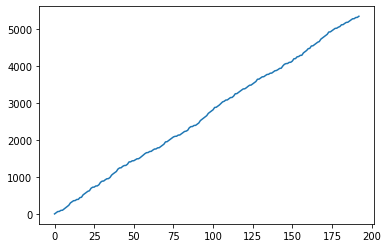

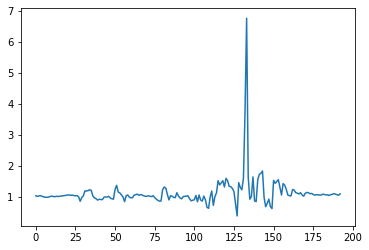

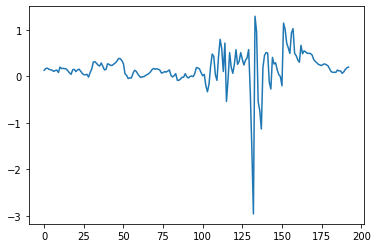

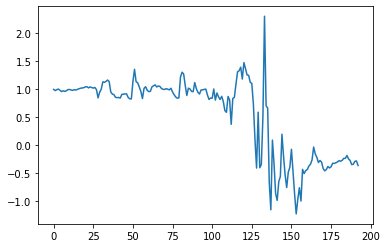

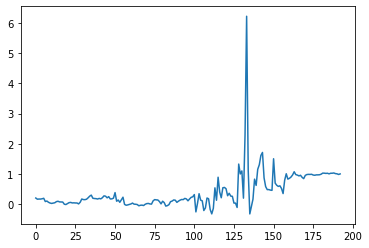

In [4]:
# Drawing some charts over a random fall training set
df = pd.read_csv(raw_files_fall_train[0], names=['TimeSinceSeqStart','SVtotal','Ax','Az','Ay'])
df.head()
plt.figure(); plt.plot(df['TimeSinceSeqStart']) # Not a really important chart from an analytical prospective for what we are aiming to show, but still interesting. Since the behaviour of this chart is almost linear, we can see that the sampling frequency is almost constant over the entire experiment. 
plt.figure(); plt.plot(df['SVtotal']) # Interpolated accelerometric data 
plt.figure(); plt.plot(df['Ax'])  # Interpolated accelerometric data for the sensor in x
plt.figure(); plt.plot(df['Az']) # Interpolated accelerometric data for the sensor in z
plt.figure(); plt.plot(df['Ay']) # Interpolated accelerometric data for the sensor in y

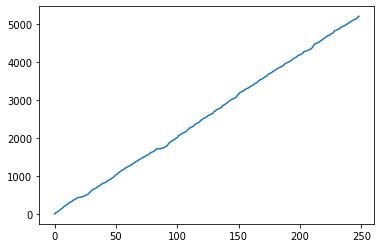

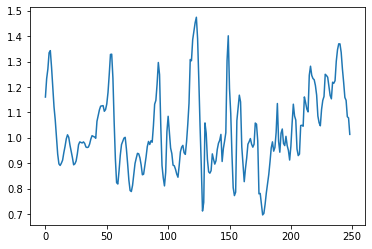

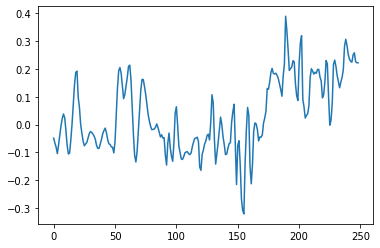

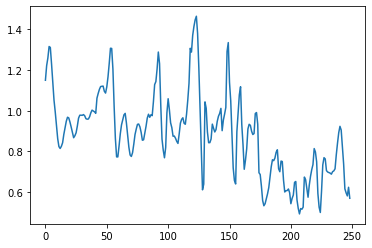

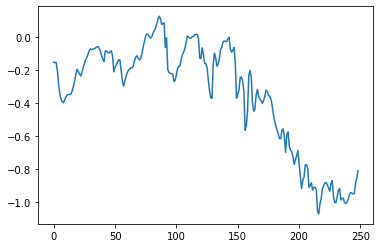

In [5]:
# Drawing some charts over a random ADL training set
df = pd.read_csv(raw_files_adl_train[0], names=['TimeSinceSeqStart','SVtotal','Ax','Az','Ay'])
df.head()
plt.figure(); plt.plot(df['TimeSinceSeqStart']) # Not a really important chart from an analytical prospective for what we are aiming to show, but still interesting. Since the behaviour of this chart is almost linear, we can see that the sampling frequency is almost constant over the entire experiment. 
plt.figure(); plt.plot(df['SVtotal']) # Interpolated accelerometric data 
plt.figure(); plt.plot(df['Ax'])  # Interpolated accelerometric data for the sensor in x
plt.figure(); plt.plot(df['Az']) # Interpolated accelerometric data for the sensor in z
plt.figure(); plt.plot(df['Ay']) # Interpolated accelerometric data for the sensor in y

My initial impression is that the fall data indeed seems much more abrupt, while the ADL data is much more stable/oscilatory over a limited range of amplitude.  

### My second step is to curate this data into conciser datasets, which will make it easier for our analytical processing.

In [6]:
# I created a function to curate this data
# The principle of operation behind it is to take all the individual files representing each experiment and create a single one that aggregates only relevant metrics from each experiment 

def curate_data(curated_file_name, raw_files, is_fall):
    try:
        os.remove(curated_file_name)
    except OSError:
        pass
    with(open(curated_file_name, 'a')) as f_curated:
        csv_writer = csv.writer(f_curated, delimiter=',', lineterminator = '\n')
        curated_features = ['id', 'file_name',
                            'SVtotal_mean', 'SVtotal_stddev', 'SVtotal_max', 'SVtotal_min',
                            'Ax_mean', 'Ax_stddev', 'Ax_max', 'Ax_min',
                            'Ay_mean', 'Ay_stddev', 'Ay_max', 'Ay_min',
                            'Az_mean', 'Az_stddev', 'Az_max', 'Az_min', 'is_fall']
        csv_writer.writerow(curated_features)

        for id, raw_file in enumerate(raw_files):
            df_raw = pd.read_csv(raw_file, names=['TimeSinceSeqStart','SVtotal','Ax','Az','Ay'])
            metrics = [id, raw_file,
            df_raw.SVtotal.mean(), df_raw.SVtotal.std(), df_raw.SVtotal.max(), df_raw.SVtotal.min(),
            df_raw.Ax.mean(), df_raw.Ax.std(), df_raw.Ax.max(), df_raw.Ax.min(),
            df_raw.Ay.mean(), df_raw.Ay.std(), df_raw.Ay.max(), df_raw.Ay.min(),
            df_raw.Az.mean(), df_raw.Az.std(), df_raw.Az.max(), df_raw.Az.min(), is_fall
            ]

            csv_writer.writerow(metrics)

In [7]:
fall_train_curated_file_name = 'Data/Curated/Fall/train.csv'
fall_test_curated_file_name = 'Data/Curated/Fall/test.csv'
adl_train_curated_file_name = 'Data/Curated/ADL/train.csv'
adl_test_curated_file_name = 'Data/Curated/ADL/test.csv'

curate_data(fall_train_curated_file_name, raw_files_fall_train, True)
curate_data(fall_test_curated_file_name, raw_files_fall_test, True)
curate_data(adl_train_curated_file_name, raw_files_adl_train, False)
curate_data(adl_test_curated_file_name, raw_files_adl_test, False)

In [8]:
# Demonstrating the results generated by the data curation process:

print('Curated fall training data: ')
df = pd.read_csv(fall_train_curated_file_name, index_col=0)
df.head()

Curated fall training data: 


,file_name,SVtotal_mean,SVtotal_stddev,SVtotal_max,SVtotal_min,Ax_mean,Ax_stddev,Ax_max,Ax_min,Ay_mean,Ay_stddev,Ay_max,Ay_min,Az_mean,Az_stddev,Az_max,Az_min,is_fall
id,,,,,,,,,,,,,,,,,,
0,Data/Raw/Fall/Train/fall-01-acc.csv,1.114739,0.498737,6.754587,0.374243,0.163529,0.382989,1.291112,-2.960764,0.410110,0.612384,6.215321,-0.318848,0.544009,0.694784,2.308085,-1.236579,True
1,Data/Raw/Fall/Train/fall-02-acc.csv,1.118166,0.534339,6.263861,0.347286,0.340905,0.258879,0.959245,-1.525458,0.543390,0.624539,6.012909,-0.155494,0.322975,0.754080,1.469942,-2.013064,True
2,Data/Raw/Fall/Train/fall-03-acc.csv,1.074644,0.260857,3.397539,0.652386,0.226363,0.259330,1.107861,-1.165342,0.383636,0.489281,2.643391,-0.270701,0.621726,0.577160,2.200737,-1.218893,True
3,Data/Raw/Fall/Train/fall-04-acc.csv,1.166289,0.687620,5.787127,0.366596,0.281375,0.300971,0.975949,-0.991179,0.751818,0.715716,5.786424,0.192095,-0.086686,0.764465,0.917486,-2.900827,True
4,Data/Raw/Fall/Train/fall-05-acc.csv,1.170181,0.861570,11.401265,0.529098,0.181788,0.737883,8.010252,-3.435351,0.360164,0.640830,8.019095,-1.094842,0.409005,0.912108,1.988991,-2.899353,True


### My third step is to apply a "UNION ALL" command between the test data for ADL and Falls; and the train data for ADL and Falls. This way, I will generate single train and test datasets. This data, which is a perfect fit for analysis, will be stored in the Analytics folder. 

In [9]:
train_analytics_file_name = 'Data/Analytics/train.csv'
test_analytics_file_name = 'Data/Analytics/test.csv'

In [10]:
# Generates the analytics training set
df_adl_train = pd.read_csv(adl_train_curated_file_name, index_col=0)
df_fall_train = pd.read_csv(fall_train_curated_file_name, index_col=0)
df_train = pd.concat([df_adl_train, df_fall_train], ignore_index=True)
df_train.to_csv(train_analytics_file_name, index=False)

In [11]:
# Generates the analytics testing set
df_adl_test = pd.read_csv(adl_test_curated_file_name, index_col=0)
df_fall_test = pd.read_csv(fall_test_curated_file_name, index_col=0)
df_test = pd.concat([df_adl_test, df_fall_test], ignore_index=True)
df_test.to_csv(test_analytics_file_name, index=False)

### My fourth step is to apply a Machine Learning Classifier to forecast whether a given sample is a fall or not

In [12]:
# Applying SVC to the fall data
df_train = pd.read_csv(train_analytics_file_name)
X_train = df_train.drop(['file_name', 'is_fall'], axis='columns')
# I will standardize the scale of all the features for the training set as this is a best practice when using SVMs
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
y_train = df_train['is_fall']

df_test = pd.read_csv(test_analytics_file_name)
X_test = df_test.drop(['file_name', 'is_fall'], axis='columns')
# I will also standardize the scale of all the features for the testing set as this is a best practice when using SVMs
X_test_std = stdsc.fit_transform(X_test)
y_test = df_test['is_fall']

svc = svm.SVC()
svc.fit(X_train_std, y_train)

print("Training dataset score:", svc.score(X_train_std, y_train))
print("Test dataset score:", svc.score(X_test_std, y_test))

Training dataset score: 0.9827586206896551
Test dataset score: 1.0


In [13]:
# Next, I will write the forecasted values to a dedicated file
forecast_analytics_file_name = 'Data/Analytics/forecast.csv'

y_pred = svc.predict(X_test_std)

df_pred = X_test.copy()
df_pred['is_fall_actual'] = y_test
df_pred['is_fall_pred'] = y_pred

df_pred.to_csv(forecast_analytics_file_name, index=False)

print("Test Dataset Forecasted")
df_pred.head()

Test Dataset Forecasted


,SVtotal_mean,SVtotal_stddev,SVtotal_max,SVtotal_min,Ax_mean,Ax_stddev,Ax_max,Ax_min,Ay_mean,Ay_stddev,Ay_max,Ay_min,Az_mean,Az_stddev,Az_max,Az_min,is_fall_actual,is_fall_pred
0,0.974633,0.577838,2.944164,-0.136538,0.328270,0.215149,0.880906,-0.192761,0.711625,0.484816,2.313328,-0.161171,0.539199,0.317057,1.631089,-0.066154,False,False
1,1.034797,0.418736,2.535667,-0.129520,-0.061397,0.437563,0.719172,-1.437567,0.247052,0.174491,0.934310,-0.177557,0.899390,0.379780,2.300972,-0.423250,False,False
2,1.125313,0.476343,3.731273,-0.452330,-0.019333,0.359912,1.071069,-0.701054,-0.472086,0.378692,0.366295,-2.779656,0.868635,0.477054,2.551468,-0.646036,False,False
3,1.023122,0.424218,2.634675,-0.369474,-0.292519,0.445837,0.920774,-1.397023,0.358620,0.417074,1.664929,-0.547366,0.694973,0.403938,1.808691,-0.515872,False,False
4,1.030468,0.437429,2.641648,-0.339369,-0.471230,0.500298,0.733698,-1.902290,0.575388,0.451394,1.639418,-0.815177,-0.214898,0.403824,0.910762,-1.558818,False,False


I got a good accuracy, but there is always room for improvement.
### My fourth step is to apply some feature selection techniques to improve the performance of the ML classifier or to identify the most relevant features for analysis.


Training dataset score: 1.0
Test dataset score: 0.8333333333333334

Features importance: 

 1) Az_min                         0.254306
 2) SVtotal_max                    0.213749
 3) SVtotal_stddev                 0.192942
 4) Az_stddev                      0.080862
 5) Ay_stddev                      0.045089
 6) Az_mean                        0.043364
 7) Ay_max                         0.038537
 8) SVtotal_mean                   0.036210
 9) SVtotal_min                    0.035650
10) Ax_stddev                      0.014690
11) Ax_mean                        0.010213
12) Ax_min                         0.010105
13) Az_max                         0.009812
14) Ay_mean                        0.008871
15) Ax_max                         0.003014
16) Ay_min                         0.002585


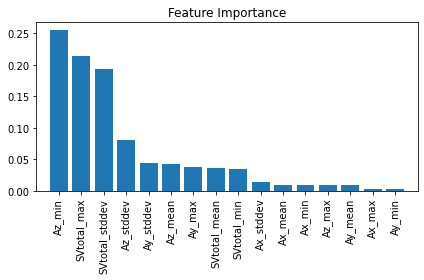

In [14]:
# Using a RandomForestClassifier to assess feature importance

# Fitting the model
# Random Forests do not require scaling
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

print("Training dataset score:", forest.score(X_train, y_train))
print("Test dataset score:", forest.score(X_test, y_test))

importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

feat_labels = df_train.columns[1:]

print("\nFeatures importance: \n")
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [15]:
# Limiting the number of features being used with SelectFromModel

# Setting a threshold of 10% for feature importance based in our forest model
sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
X_selected = sfm.transform(X_train)
print('Number of features that meet the threshold criterion:', 
      X_selected.shape[1])
print('Feature names: ')
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

Number of features that meet the threshold criterion: 3
Feature names: 
 1) Az_min                         0.254306
 2) SVtotal_max                    0.213749
 3) SVtotal_stddev                 0.192942


In [16]:
# Retraining my models using only the 4 features that were selected by SFM

In [17]:
df_train_reshaped = df_train[['SVtotal_stddev','Az_min','SVtotal_max','Az_stddev', 'is_fall']]
df_test_reshaped = df_test[['SVtotal_stddev','Az_min','SVtotal_max','Az_stddev', 'is_fall']]

X_train_reshaped = df_train_reshaped.drop(['is_fall'], axis='columns')
X_test_reshaped = df_test_reshaped.drop(['is_fall'], axis='columns')

In [18]:
# Retraining the SVC

stdsc = StandardScaler()
X_train_reshaped_std = stdsc.fit_transform(X_train_reshaped)
X_test_reshaped_std = stdsc.fit_transform(X_test_reshaped)

svc = svm.SVC()
svc.fit(X_train_reshaped_std, y_train)

print("Training dataset score:", svc.score(X_train_reshaped_std, y_train))
print("Test dataset score:", svc.score(X_test_reshaped_std, y_test))

Training dataset score: 0.9655172413793104
Test dataset score: 1.0


In [19]:
# Retraining the RandomForest

forest = RandomForestClassifier()
forest.fit(X_train_reshaped, y_train)

print("Training dataset score:", forest.score(X_train_reshaped, y_train))
print("Test dataset score:", forest.score(X_test_reshaped, y_test))

Training dataset score: 1.0
Test dataset score: 0.5
